* Look at time difference between Fraser stations max U velocity with Central Node max V velocity to see how surface currents go around.

In [1]:
from __future__ import division, print_function

from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from salishsea_tools.nowcast import figures
from salishsea_tools.nowcast import analyze

from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import glob
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 77, #426 start from 349 fortran start from 350
        'j' : 34, #293 start from 259 fortran start from 260
   
    },
    'Steveston Jetty':{
        'lat': 49.1057,
        'lon': -123.3032,
        'i' :  79,#428
        'j' :  33,#292
    },
    'Deas Island':{
        'lat' : 49.12,
        'lon' : -123.07,
        'i' : 65,#414,
        'j' : 69,#328
    },  
    'Deas Island north':{
        'lat': 49.13,
        'lon': -123.08,
        'i': 67,  ##416
        'j': 69, ##328
    },
    'New Westminster': {
        'lat': 49.21,
        'lon': -122.89,
        'i': 69,#418,
        'j': 106,#365
        },

    'Mission': {
        'lat': 49.528,## this is in our model,not on the googlemap
        'lon': -123.16,
        'i':  151,#500,
        'j':108,#367
    },
    'VENUS East':{
        'lat': 49.0419,
        'lon': -123.3176,
        'depth': 170, 
        'i': 67,##should be 416,
        'j': 24,##should be 283
    },
    'VENUS Central':{
        'lat': 49.0401,
        'lon': -123.4261,
        'depth': 300,
        'i': 75,##should be 424,
        'j': 7,##should be 266
    },
           }

## location of Steveston from EC is:
#-123.185, 49.1242, so 13km away from
#our location for that in the model 

# Load new simulation result for new bathymetry & nowcasts

In [3]:
fB = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
fB_new = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')

In [4]:
plume_u = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume06160629gridU.nc')
plume_v = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume06160629gridV.nc')
plume_u_nownew = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast06160629gridU.nc')
plume_v_nownew = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast06160629gridV.nc')

In [5]:
u = plume_u.variables['vozocrtx']
v = plume_v.variables['vomecrty']
u
u_nownew = plume_u_nownew.variables['vozocrtx']
v_nownew = plume_v_nownew.variables['vomecrty']
time = plume_u.variables['time_counter'][:]
t = nc_tools.timestamp(plume_u, np.arange(time.shape[0]))
for ind in range(len(t)):
    t[ind] = t[ind].datetime
tt = np.array(t) ## convert time_counter into datetime

* Combine daily nowcasts files into a time series one

In [6]:
to = datetime.datetime(2015,6,16)
tf = datetime.datetime(2015,6,29)
files_U = analyze.get_filenames(to,tf,'1h','grid_U','/data/dlatorne/MEOPAR/SalishSea/nowcast/')
files_V = analyze.get_filenames(to,tf,'1h','grid_V','/data/dlatorne/MEOPAR/SalishSea/nowcast/')

In [10]:
def plot_UV_timeseries_new(tt,sites, station_name, u, v, u_nownew, v_nownew, fB, fB_new):
    """This function was made to look at time difference
        of U velocity in the Fraser River and V velocity
        at East Node 
        tt: time series
        sites: with a variety of station names
        statin_name: the specific station name I want to look at
        u: U velocity array for new river treatment
        v: V velocity array for new river treatment
        u_nownew: """
    fig = plt.figure(figsize=(26,16))
    #fig.patch.set_facecolor('#2B3E50')
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])
    gs.update(wspace=0.13, hspace=0.2)
    ax0 = fig.add_subplot(gs[0, 1])  # information box
    ax1 = fig.add_subplot(gs[1, 1])  # sea surface height
    ax2 = fig.add_subplot(gs[0, 0])  # map
    ax3 = fig.add_subplot(gs[1, 0])  #map
    axs = [ax0, ax1]
    axss = [ax2, ax3]
        
    uu = [u, u_nownew]
    vv = [v, v_nownew]
    titles = ['deepened case','nowcasts from cold start']
    bathy = [fB_new, fB]
    zero_line = np.zeros(tt.shape)
    #fig, axs = plt.subplots(2,1, figsize = (22,14))
    for ax, ui,vi, title in zip(axs, uu, vv, titles):
        ST, = ax.plot(tt, ui[:, 0, sites[station_name]['i'],\
                         sites[station_name]['j']],'b*-')
        EN, = ax.plot(tt, vi[:, 0, sites['VENUS East']['i'],\
                         sites['VENUS East']['j']],'ro-')## east node
        CN, = ax.plot(tt, vi[:, 0, sites['VENUS Central']['i'], \
                         sites['VENUS Central']['j']],'go-')## central node
        ax.plot(tt,zero_line,'-k')
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.legend([ST,EN, CN],[station_name,'East node','Central node'],loc = 1, fontsize = 15)
        ax.set_ylim([-1.5, 1.2])
        ax.set_ylabel('U,V velocity [m/s]', fontsize = 15)
        ax.set_title(title, fontsize = 15) 
    for ax, bathyy in zip(axss, bathy):
        viz_tools.plot_land_mask(ax, bathyy, coords='map')
        viz_tools.plot_coastline(ax, bathyy, coords='map', isobath=5)
        ax.plot(sites['VENUS Central']['lon'], sites['VENUS Central']['lat'], 'g*', markersize = 15)
        ax.plot(sites['VENUS East']['lon'], sites['VENUS East']['lat'], 'r*', markersize = 15)
        ax.plot(sites[station_name]['lon'], sites[station_name]['lat'], 'bo', markersize = 10)
        ax.set_xlim([-123.8,-122.8])
        ax.set_ylim([48.8,49.6])
    return fig

In [16]:
def plot_UV_timeseries_nowcast(tt,sites, station_name, files_U,files_V, fB):
    """This function was made to look at time difference
        of U velocity in the Fraser River and V velocity
        at East Node 
        tt: time series
        sites: with a variety of station names
        statin_name: the specific station name I want to look at
        files_U: combination grid_U from 16 to 29,June of nowcasts results
        files_V: combination grid_U from 16 to 29,June of nowcasts results"""
    fig = plt.figure(figsize=(26,8))
    #fig.patch.set_facecolor('#2B3E50')
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
    gs.update(wspace=0.13, hspace=0.2)
    ax0 = fig.add_subplot(gs[0, 1])  # nowcasts results
    ax1 = fig.add_subplot(gs[0, 0])  # map
    
    u_now, time = analyze.combine_files(files_U, 'vozocrtx',0,sites[station_name]['i'] + 349,\
                                       sites[station_name]['j'] + 259 )
    v_now_cen, time = analyze.combine_files(files_V, 'vomecrty',0,\
        sites['VENUS Central']['i'] + 349,sites['VENUS Central']['j'] + 259 )
    v_now_east, time = analyze.combine_files(files_V, 'vomecrty',0,\
        sites['VENUS East']['i'] + 349,sites['VENUS East']['j'] + 259 )
    #uu = [u, u_nownew]
    #vv = [v, v_nownew]
    #titles = ['deepened case','nowcasts from cold start']
    #bathy = [fB_new, fB]
    zero_line = np.zeros(tt.shape)
    #fig, axs = plt.subplots(2,1, figsize = (22,14))
    #for ax, ui,vi, title in zip(axs, uu, vv, titles):
    ST, = ax0.plot(tt, u_now,'b*-')
    EN, = ax0.plot(tt, v_now_east,'ro-')## east node
    CN, = ax0.plot(tt, v_now_cen,'go-')## central node
    ax0.plot(tt,zero_line,'-k')
    plt.setp(ax0.get_xticklabels(), fontsize=20)
    plt.setp(ax0.get_yticklabels(), fontsize=20)
    ax0.legend([ST,EN, CN],[station_name,'East node','Central node'],loc = 1, fontsize = 15)
    ax0.set_ylim([-1.5, 1.2])
    ax0.set_ylabel('U,V velocity [m/s]', fontsize = 15)
    ax0.set_title('nowcasts', fontsize = 15) 
    #for ax, bathyy in zip(axss, bathy):
    viz_tools.plot_land_mask(ax1, fB, coords='map')
    viz_tools.plot_coastline(ax1, fB, coords='map', isobath=5)
    ax1.plot(sites['VENUS Central']['lon'], sites['VENUS Central']['lat'], 'g*', markersize = 15)
    ax1.plot(sites['VENUS East']['lon'], sites['VENUS East']['lat'], 'r*', markersize = 15)
    ax1.plot(sites[station_name]['lon'], sites[station_name]['lat'], 'bo', markersize = 10)
    ax1.set_xlim([-123.8,-122.8])
    ax1.set_ylim([48.8,49.6])
    return fig

# Plot

* Sandheads 

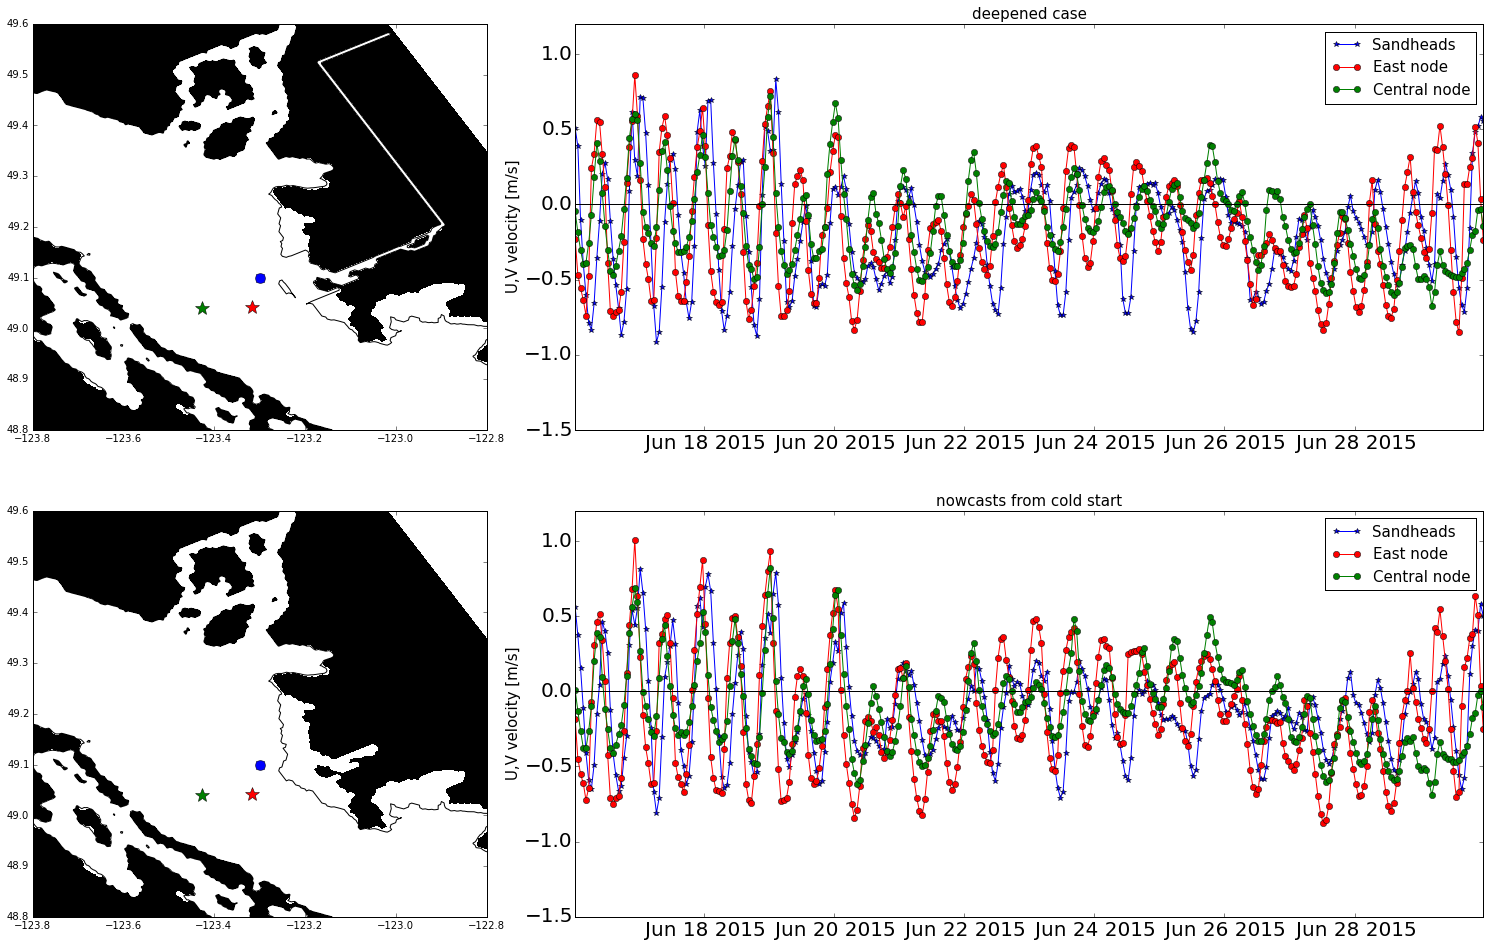

In [8]:
fig = plot_UV_timeseries_new(tt, sites, 'Sandheads', u, v, u_nownew, v_nownew, fB, fB_new)

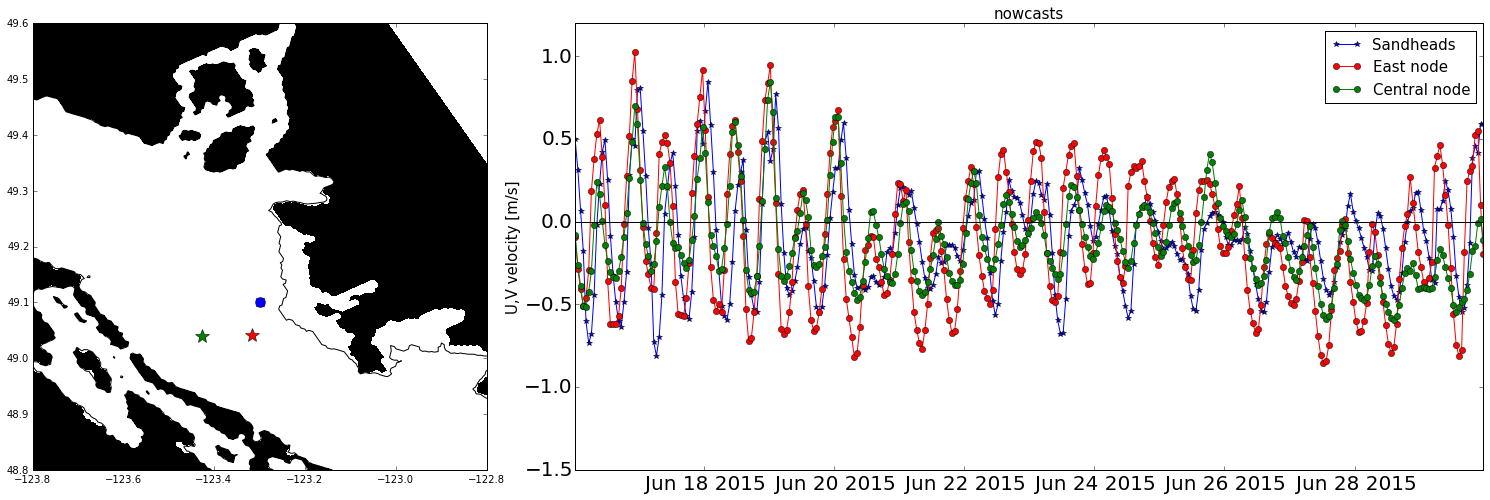

In [17]:
fig = plot_UV_timeseries_nowcast(tt,sites, 'Sandheads', files_U,files_V, fB)

* Deas Island Channel 

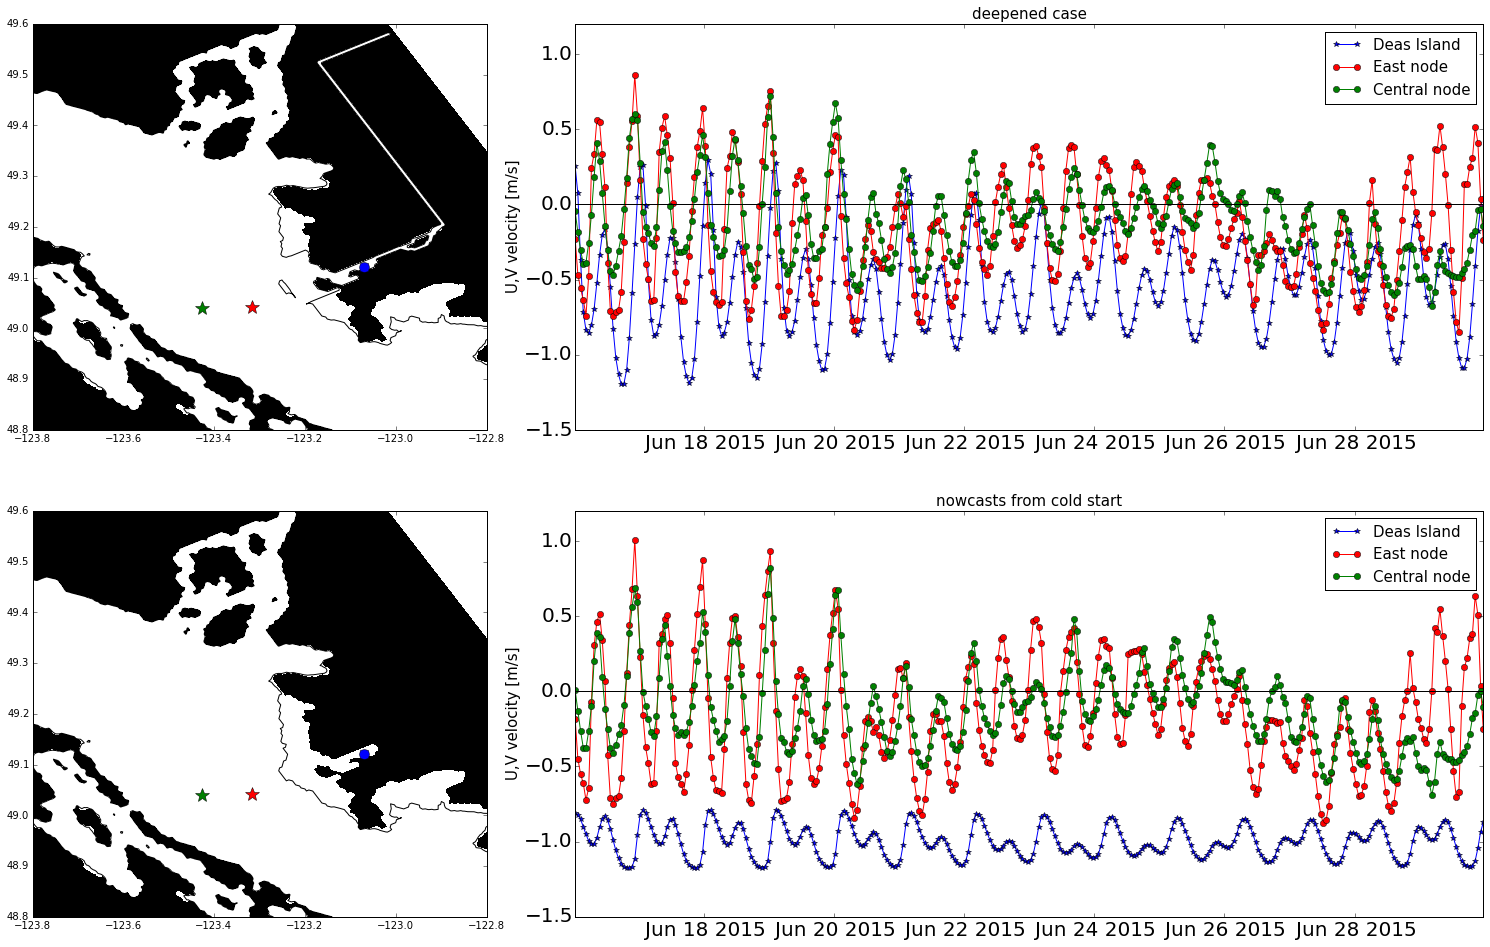

In [9]:
fig = plot_UV_timeseries_new(tt, sites, 'Deas Island', u, v, u_nownew, v_nownew, fB, fB_new)

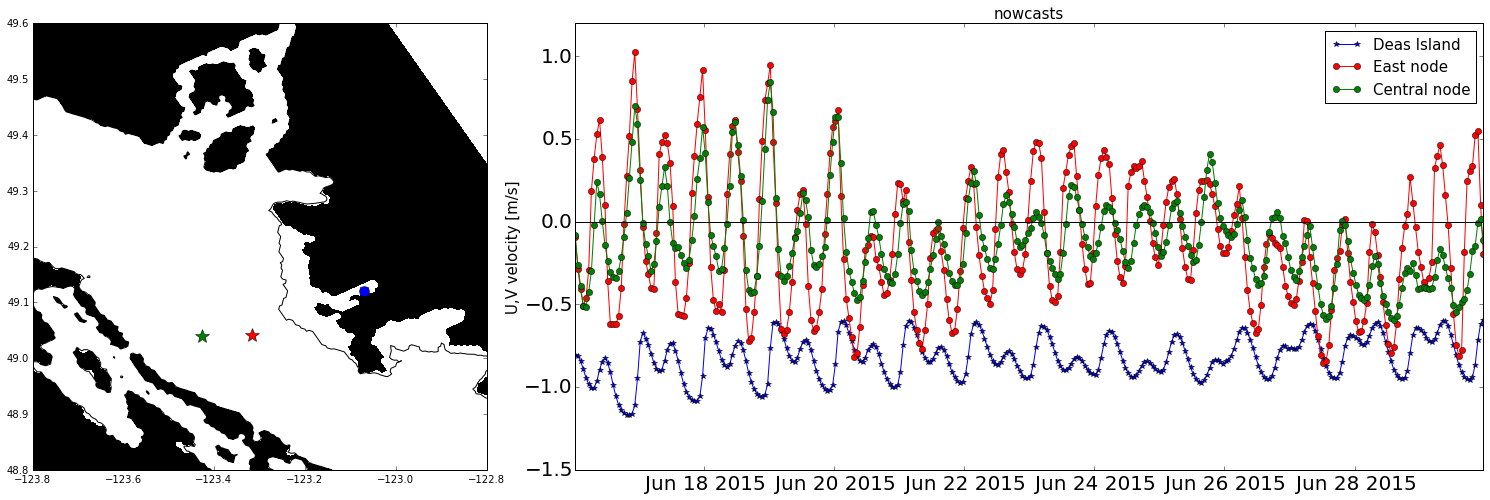

In [18]:
fig = plot_UV_timeseries_nowcast(tt,sites, 'Deas Island', files_U,files_V, fB)

* Flood tide for new: U > 0, V max occurs first, makes sense to me.
* Ebb tide for new: U < 0, V max occurs first as well, for example, Deas Island Umax 1hr later than Vmax at East node, does this mean Umax has propagate in the strait already??
* For nowcasts from cold start, U velocity for Deas Island is always directed towards strait, which means it tides could not go further to Deas Island even during flood tide. Still time lag compared with East/Central node. Could see the surface currents cycle in the strait?? 

* Deas Island north

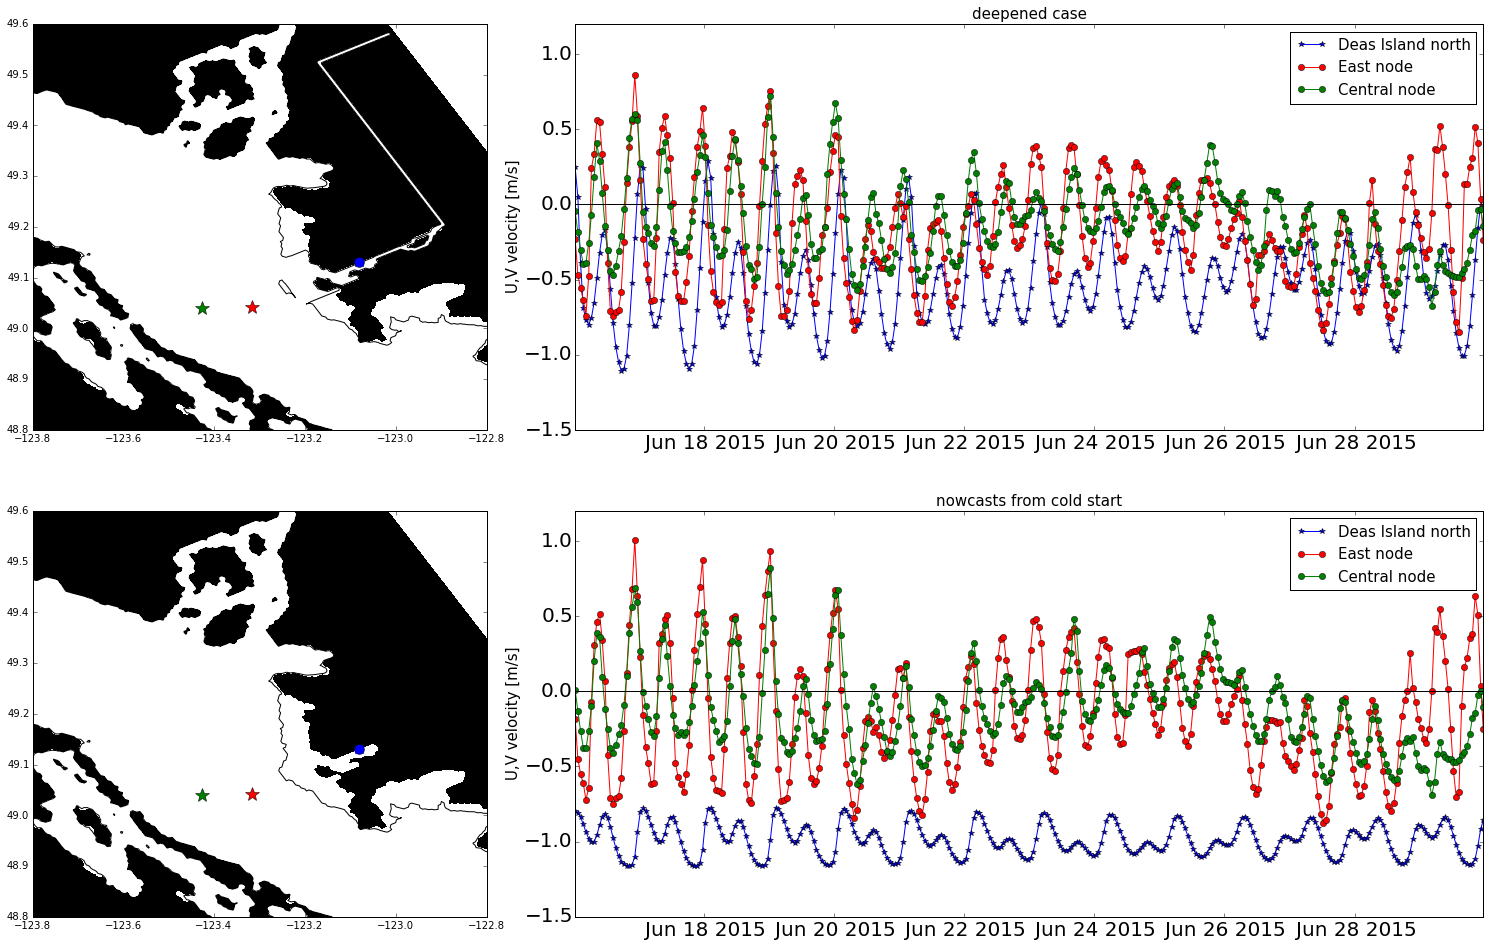

In [10]:
fig = plot_UV_timeseries_new(tt, sites, 'Deas Island north', u, v, u_nownew, v_nownew, fB, fB_new)

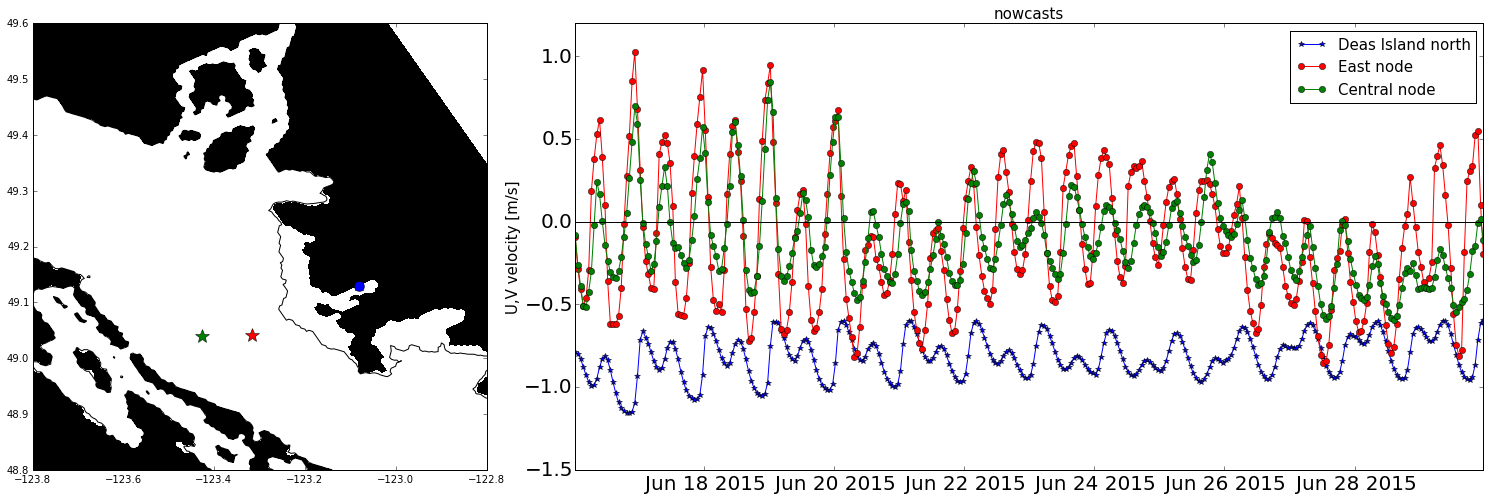

In [19]:
fig = plot_UV_timeseries_nowcast(tt,sites, 'Deas Island north', files_U,files_V, fB)

* New Westminster has no U velocity due to the river channel I made, it's at the corner direct to north

  * Mission 

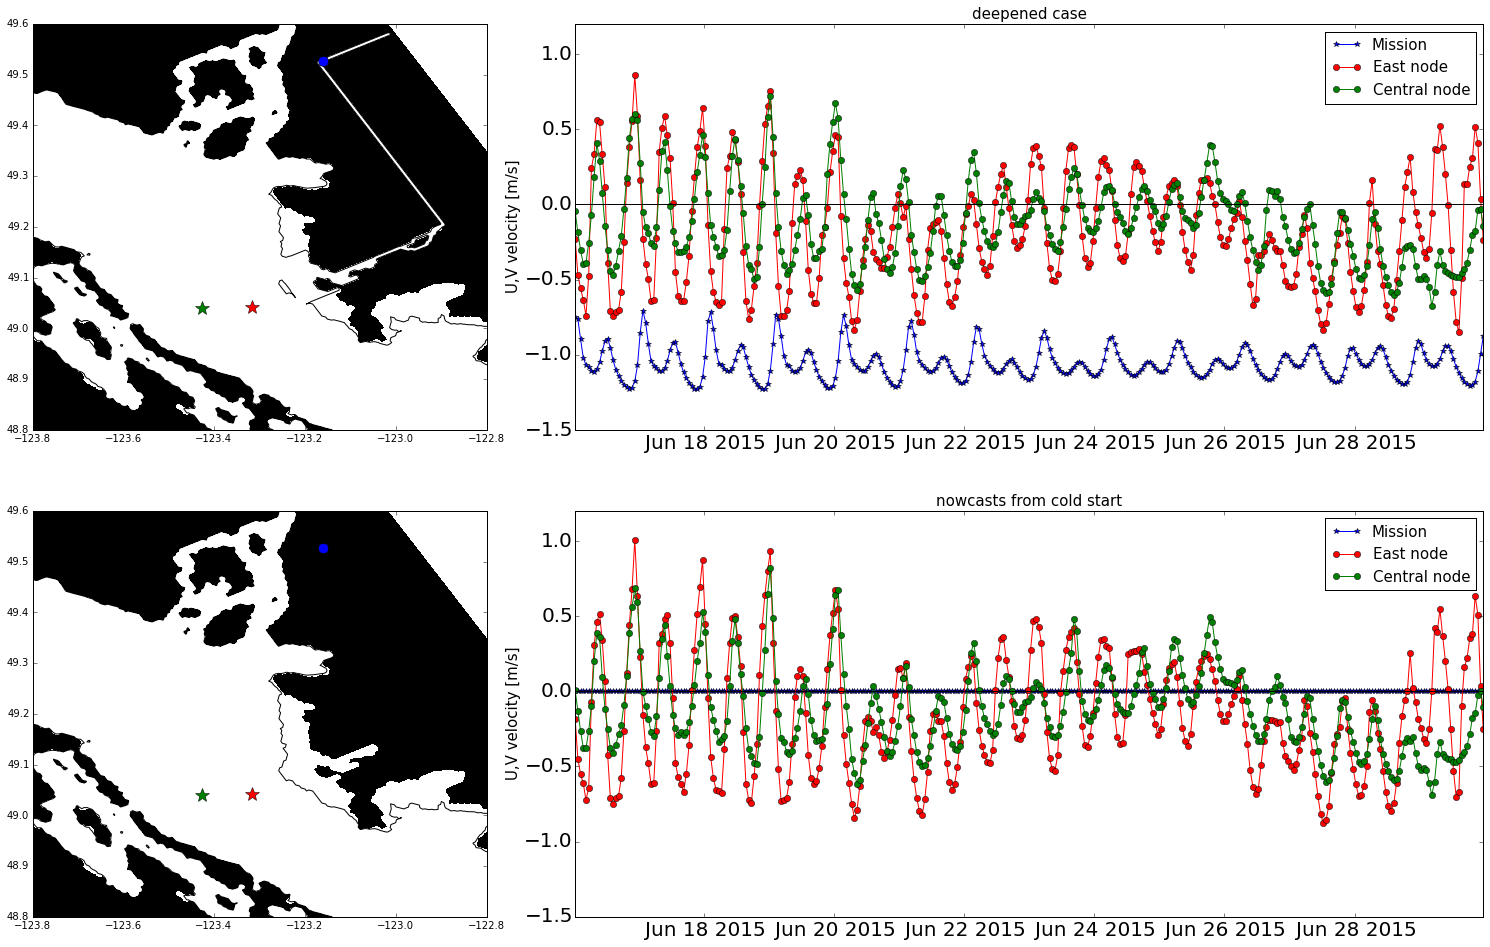

In [12]:
fig = plot_UV_timeseries_new(tt, sites, 'Mission', u, v, u_nownew, v_nownew,fB, fB_new)

* U always negative in Mission no matter flood/ebb tide. In this case, U should be a combination of river flow velocity and tidal current velocity. U still has daily signal variation which means Mission in our model is still affected by tides.